In [81]:
import numpy as np
import pickle
import pandas as pd
import re
import unicodedata

In [82]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Merge player stats

In [83]:
with open('player_stats.pickle', 'rb') as handle:
    player_stats = pickle.load(handle)

In [84]:
all_seasons = []
for season_stats in player_stats:
    all_teams = []
    for team_stats in season_stats:
        team = pd.concat(team_stats, axis=1)
        all_teams.append(team)
    all_teams = pd.concat(all_teams, axis=0)
    all_seasons.append(all_teams)
all_stats = pd.concat(all_seasons)

## Clean column name

In [85]:
all_stats = all_stats.rename(columns = lambda x: re.sub(r'(Unnamed: \d_\w+_\d\s)|(\sUnnamed: \d_\w+_\d)|(\sUnnamed: \d_\w+_\d\s)', '', x))

In [86]:
all_stats = all_stats.loc[:,~all_stats.columns.duplicated()]

# Merge on off stats

In [87]:
with open('onoff_stats.pickle', 'rb') as handle:
    onoff_stats = pickle.load(handle)

In [88]:
all_seasons = []
for season_stats in onoff_stats:
    all_teams = []
    for team_stats in season_stats:
        team = pd.concat(team_stats, axis=1)
        all_teams.append(team)
    all_teams = pd.concat(all_teams, axis=0)
    all_seasons.append(all_teams)
all_stats_on_off = pd.concat(all_seasons)

## Clean column name

In [89]:
all_stats_on_off = all_stats_on_off.rename(columns = lambda x: re.sub(r'(Unnamed: \d_\w+_\d\s)|(\sUnnamed: \d_\w+_\d)|(\sUnnamed: \d_\w+_\d\s)', '', x))

In [90]:
all_stats_on_off.drop([x for x in list(all_stats_on_off.columns) if re.search(r'Unnamed', x)], axis=1, inplace=True)

In [91]:
all_stats_on_off = all_stats_on_off.loc[:,~all_stats_on_off.columns.duplicated()]

In [92]:
all_stats_on_off.shape

(9638, 103)

# Filter free agents

In [93]:
with open('free_agents.pickle', 'rb') as handle:
    free_agents = pickle.load(handle)

In [94]:
all_stats = all_stats.drop_duplicates(['Player', 'season'])

In [95]:
all_stats_on_off = all_stats_on_off.drop_duplicates(['Player', 'season'])

## Fix name encoding before merge

In [96]:
def fix_encoding(string):
    return unicodedata.normalize('NFKD', string).encode("ascii","ignore").decode()

In [97]:
free_agents['Player'] = free_agents['Player'].apply(fix_encoding)

## Fixing dot in first name before merge

In [98]:
def fix_dot(string):
    if string.count('.') > 1:
        clean = "".join(re.findall(r'[\w]+', string))
        return clean[:2] + " " + clean[2:]
    else:
        return string

In [99]:
free_agents['Player'] = free_agents['Player'].apply(fix_dot)

In [100]:
free_agents_stats = free_agents.merge(all_stats, how='left',
            left_on=['Player', 'previous season'],
            right_on=['Player', 'season']).merge(all_stats_on_off, how='left',
                                                left_on=['Player', 'previous season'],
                                                right_on=['Player', 'season'])

In [101]:
free_agents_stats.info('memory_usage'=='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4321 entries, 0 to 4320
Columns: 188 entries, Player to Opponent Shot Frequency AllThree #
dtypes: float64(113), object(75)
memory usage: 6.2+ MB


# Data Cleaning

In [102]:
import seaborn as sns

In [103]:
columns = free_agents_stats.columns

In [104]:
free_agents_stats.shape[0]

4321

In [105]:
columns_to_drop = []
for c in columns:
    if free_agents_stats[c].isnull().sum() == free_agents_stats.shape[0]:
        columns_to_drop.append(c)

In [106]:
free_agents_stats.drop(columns=columns_to_drop, inplace=True)

In [107]:
free_agents_stats.drop([c for c in free_agents_stats if c[-1] == '%'], axis=1, inplace=True)

free_agents_stats.drop(columns=['MIN_y', 'id_y', 'season_y'], inplace=True)

free_agents_stats.rename({'MIN_x': 'MIN', 'id_x': 'id', 'season_x': 'season',
                          'eFG% %_x': 'Player eFG% %', 'eFG% #_x': 'Player eFG% #',
                          'eFG% %_y': 'Team eFG% %', 'eFG% #_y': 'Team eFG% #'}, axis=1, inplace=True)

<AxesSubplot:>

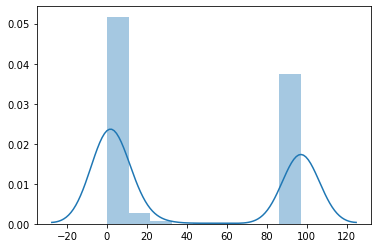

In [108]:
sns.distplot(a=free_agents_stats.apply(pd.Series.isnull, axis=0).apply(pd.Series.sum, axis=1).values)

In [109]:
free_agents_stats = free_agents_stats.loc[~free_agents_stats.apply(pd.Series.isnull, axis=0).apply(pd.Series.sum, axis=1).apply(lambda x: x >= free_agents_stats.shape[1]/3), :]

In [110]:
free_agents_stats = free_agents_stats.fillna(free_agents_stats.mean())

<ipython-input-110-67b8095275f4>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  free_agents_stats = free_agents_stats.fillna(free_agents_stats.mean())


In [111]:
free_agents_stats.fillna(0, inplace=True)

# Merge salary

In [112]:
free_agents_stats['Next season'] = free_agents_stats['season'].apply(lambda x: str(int(x[:4])+1) + "-" + str(int(x[:4])+2)[2:])

In [113]:
with open("player_salaries.pickle", 'rb') as handle:
    player_salaries = pickle.load(handle)

In [114]:
player_salaries = pd.concat(player_salaries, axis=0)

In [115]:
stats_salaries = free_agents_stats.merge(player_salaries, how='left',
                        left_on=['Player', 'Next season'], right_on=['Player', 'season'])

In [116]:
stats_salaries = stats_salaries.loc[~stats_salaries['Salary'].isnull()]

In [117]:
stats_salaries.drop(columns=['season_x', 'season_y'], inplace=True)

# Merge salary cap

In [118]:
salary_caps = pd.read_excel('salary_caps.xlsx')

In [119]:
salary_caps = salary_caps[['season', 'salary_cap']]

In [120]:
stats_salaries_cap = stats_salaries.merge(salary_caps,
                                         how='left', left_on='Next season', right_on='season')

In [121]:
stats_salaries_cap.drop(columns=['season'], inplace=True)

In [122]:
stats_salaries_cap['Salary'].isnull().sum()

0

In [123]:
stats_salaries_cap['cap_usage'] = stats_salaries_cap['Salary'] / stats_salaries_cap['salary_cap']

# Percentage into float

In [124]:
def p2f(x):
    if 0:
        return float(0)
    return float(x.strip('%'))/100

In [125]:
for c in stats_salaries_cap.columns:
    if '#' in c:
        stats_salaries_cap[c] = stats_salaries_cap[c].apply(lambda x: float(str(x).strip('%'))/100)

In [126]:
stats_salaries_cap.drop(columns=['MIN'], inplace=True)

# Merge with BBR basic and advanced stats

In [61]:
bbr_advanced = pd.read_excel("bbr_advanced.xlsx")

In [62]:
bbr_advanced['name'] = bbr_advanced['name'].apply(lambda x: re.sub(r"\\.+", "", x))

In [64]:
bbr_advanced.drop(columns=['positions', 'age', 'team', 'games_played', 'minutes_played', 'is_combined_totals', 'slug'], inplace=True)

In [66]:
bbr_advanced = bbr_advanced.loc[~bbr_advanced.duplicated(['name', 'Year'])]

In [68]:
bbr_advanced['name'] = bbr_advanced['name'].apply(fix_encoding).apply(fix_dot)

In [127]:
stats_salaries_cap = stats_salaries_cap.merge(bbr_advanced, how='left',
                         left_on=['Player', 'previous season'],
                         right_on=['name', 'Year'])

# Merge Raptor Data from 538

In [128]:
historical = pd.read_csv('historical_RAPTOR_by_player.csv')

In [129]:
modern = pd.read_csv('modern_RAPTOR_by_player.csv')

In [130]:
historical.columns

Index(['player_name', 'player_id', 'season', 'poss', 'mp', 'raptor_offense',
       'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season',
       'war_playoffs', 'predator_offense', 'predator_defense',
       'predator_total', 'pace_impact'],
      dtype='object')

In [131]:
historical['season'] = historical['season'].apply(lambda x: str(x-1) + "-" + str(x)[2:])

In [132]:
stats_salaries_cap = stats_salaries_cap.merge(historical, how='left', left_on=['Player', 'previous season'], right_on=['player_name', 'season'])

In [133]:
stats_salaries_cap = stats_salaries_cap.loc[~stats_salaries_cap['player_name'].isnull()]

In [135]:
stats_salaries_cap.drop(columns=['player_id', 'player_name', 'mp', 'Year', 'season'], inplace=True)

In [136]:
for c in stats_salaries_cap.columns:
    if stats_salaries_cap[c].isnull().sum() != 0:
        print(c)

In [ ]:
list(stats_salaries_cap.columns

In [139]:
with open('stats_salaries_cap.pickle', 'wb') as handle:
    pickle.dump(stats_salaries_cap, handle)